## 1. Importing Required Libraries

In this step, we import all the Python libraries needed for the analysis:

- **datetime**: For handling date ranges  
- **matplotlib & numpy**: For plotting and numerical operations  
- **optuna**: For hyperparameter tuning of the model  
- **pandas**: For data manipulation and preprocessing  
- **yfinance**: To fetch historical STI stock market data  
- **sklearn.metrics**: For model evaluation metrics (MAE, RMSE)  
- **sklearn.model_selection**: For train-test splitting  
- **xgboost**: Core modeling library for forecasting  
- **warnings**: To suppress non-critical warnings for cleaner output


In [ ]:
#Importing necessary libraries
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")


## 2. Downloading Historical STI Data

Here we:
1. Define the ticker symbol for the Straits Times Index (**^STI**)
2. Calculate the start and end dates for approximately the last **5 years**.
3. Use `yfinance` to download **daily price data** within this date range.
4. Display dataset shape, date range, and first few rows to verify it has been downloaded correctly.

This forms the foundation of our analysis.


In [ ]:
# Downloading STI data from Yahoo Finance
# The Straits Times Index (STI) is a stock market index that tracks the performance of the top 30 companies listed on the Singapore Exchange.
# We will download the data for the last 5 years.
ticker_symbol = "^STI"
end_date = date.today()
start_date = end_date - timedelta(days=5 * 365)

print(f"Downloading STI data from {start_date} to {end_date}")
sti_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display basic information
print(f"\nDataset shape: {sti_data.shape}")
print(f"Date range: {sti_data.index.min()} to {sti_data.index.max()}")
print(f"\nFirst few rows:")
sti_data.head(5)

[*********************100%***********************]  1 of 1 completed


Dataset shape: (1257, 5)
Date range: 2020-08-11 00:00:00 to 2025-08-08 00:00:00

First few rows:


Price,Close,High,Low,Open,Volume
Ticker,^STI,^STI,^STI,^STI,^STI
Date,,,,,
2020-08-11,2544.149902,2559.760010,2522.800049,2547.520020,370449300
2020-08-12,2563.199951,2563.790039,2521.060059,2530.750000,313027900
2020-08-13,2595.969971,2602.330078,2568.100098,2574.800049,342499200
2020-08-14,2581.320068,2600.050049,2572.639893,2584.500000,232767800
2020-08-17,2571.550049,2596.810059,2565.020020,2580.560059,676702400


## 3. Feature Engineering

We create features that will be used by the XGBoost model for forecasting:

- **Lag Features**: Previous closing prices to help the model learn from past patterns.
- **Rolling Statistics**: Moving averages or rolling standard deviations to capture trends and volatility.
- **Date-Time Features**: Extract day, month, year, and day-of-week to incorporate time-related effects.

These engineered features help XGBoost capture both short-term and seasonal trends in the data.


In [ ]:
# Preprocessing the data
sti_data.drop(columns=['Open', 'High', 'Low', 'Volume'],inplace=True)

In [ ]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Function to add lag features
# This function adds lag features to the DataFrame for the target variable 'Close'
# The number of days to predict is specified by num_days_pred
def add_lags(df,num_days_pred=30):
    target = 'Close'
    df['lag1'] = df[target].shift(num_days_pred)  
    df['lag2'] = df[target].shift(num_days_pred*2)    
    df['lag3'] = df[target].shift(num_days_pred*3)    
    df['lag4'] = df[target].shift(num_days_pred*4)    
    df['lag5'] = df[target].shift(num_days_pred*5)
    df['lag6'] = df[target].shift(num_days_pred*6)
    df['lag7'] = df[target].shift(num_days_pred*7)
    df['lag8'] = df[target].shift(num_days_pred*8)
    df['lag9'] = df[target].shift(num_days_pred*9)
    df['lag10'] = df[target].shift(num_days_pred*10)
    df['lag11'] = df[target].shift(num_days_pred*11)
    df['lag12'] = df[target].shift(num_days_pred*12)
    return df

In [ ]:
# Function to create time series features
# This function creates features based on the time series index such as hour, day of week, month, etc.
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [ ]:
# Preparing the data for XGBoost model
# The function xgboostmodel takes a DataFrame, adds lag features, and creates time series features.
# It returns the features (X) and target variable (y) for training the XGBoost model.   
df_XGBoost=sti_data.copy()
def xgboostmodel(df_xgb,add_lags,create_features,num_days_pred=30):

    df_xgb = create_features(df_xgb)
    df_xgb = add_lags(df_xgb)
    
    X = df_xgb.drop(columns='Close')
    y = df_xgb['Close']
    return X,y

In [ ]:
# Preparing the data for XGBoost model
X,y = xgboostmodel(df_XGBoost ,add_lags,create_features,num_days_pred=30)

## 4. Hyperparameter Tuning with Optuna

We use **Optuna**, a powerful optimization framework, to find the best XGBoost hyperparameters:

- **max_depth**: Controls tree depth for capturing complexity.
- **learning_rate**: Size of each boosting step.
- **n_estimators**: Number of boosting rounds.
- **colsample_bytree**: Fraction of features considered per tree.
- **min_child_weight**, **subsample**: Regularization to avoid overfitting.

Optuna tests multiple parameter combinations and selects the one with the lowest forecast error.


In [ ]:
#Creating function to perform hyperparameter tuning using Optuna
# This function defines the objective function for Optuna to minimize the RMSE of the XGBoost model.
# It suggests hyperparameters and evaluates the model performance on a validation set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
        #'tree_method': 'gpu_hist',
    }
    
    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)
    
    # Fit the model on training data
    xgb.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = xgb.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

## 5. Train-Test Data Split

We split the dataset into:
- **Training set**: Used to train the XGBoost model (80% of the data)
- **Test set**: The remaining 20% for evaluating model performance

This ensures our predictions are tested on unseen data, avoiding overfitting and giving a realistic measure of model accuracy.


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-08-10 18:20:54,625] A new study created in memory with name: no-name-e8183fa8-9d7a-43aa-ae8a-66adf0219a15
[I 2025-08-10 18:20:55,232] Trial 0 finished with value: 45.49436295352288 and parameters: {'n_estimators': 417, 'max_depth': 4, 'learning_rate': 0.08848304166176495, 'subsample': 0.9062810642240314, 'colsample_bytree': 0.8574681786600273, 'reg_alpha': 3.4679985879360076, 'reg_lambda': 1.0441198472380253}. Best is trial 0 with value: 45.49436295352288.
[I 2025-08-10 18:20:57,222] Trial 1 finished with value: 43.38557626146117 and parameters: {'n_estimators': 719, 'max_depth': 8, 'learning_rate': 0.08761447573987471, 'subsample': 0.8190696866899738, 'colsample_bytree': 0.6816997076446132, 'reg_alpha': 0.12813836956418356, 'reg_lambda': 4.951063148038002}. Best is trial 1 with value: 43.38557626146117.
[I 2025-08-10 18:20:58,362] Trial 2 finished with value: 35.8360098852005 and parameters: {'n_estimators': 366, 'max_depth': 9, 'learning_rate': 0.09357889876600672, 'subsample

Best trial:
  Value: 33.3719531322243
  Params: 
    n_estimators: 325
    max_depth: 8
    learning_rate: 0.02528872835028195
    subsample: 0.8018115554627568
    colsample_bytree: 0.7598944542480357
    reg_alpha: 4.302966400089371
    reg_lambda: 0.46675496923463916


## 6. Training XGBoost Model

Using the best parameters from Optuna, we train an **XGBRegressor** model:

- The model learns the relationship between historical features and the target (**future closing prices**).
- Training is performed on the **training set** only.
- After training, we verify model parameters.


In [16]:
# Use the best parameters to train the final model
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7598944542480357, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02528872835028195, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=325, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Predict on the test set and calculate RMSE
y_pred_test = xgb_best.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

Test RMSE: 33.3719531322243


In [ ]:
#Error percentage calculation
y_pred_test_xgb = xgb_best.predict(X_test)
xgb_loss = mean_absolute_percentage_error(y_test, y_pred_test_xgb) 
print(f"ERROR PERCENT = { mean_absolute_percentage_error(y_test, y_pred_test_xgb) }% ")

ERROR PERCENT = 10.2215440242454% 


## 7. Plotting Training vs. Test Predictions

We visualize:
- Historical **train data**
- Actual **test data**
- XGBoost **forecasted values** for the test period

A good model will have predicted lines closely following the actual price movements.


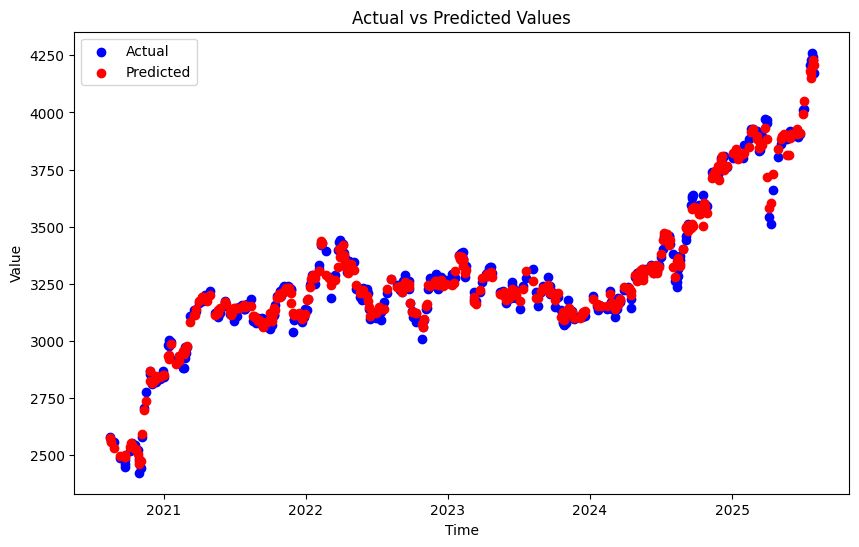

In [ ]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test_xgb , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

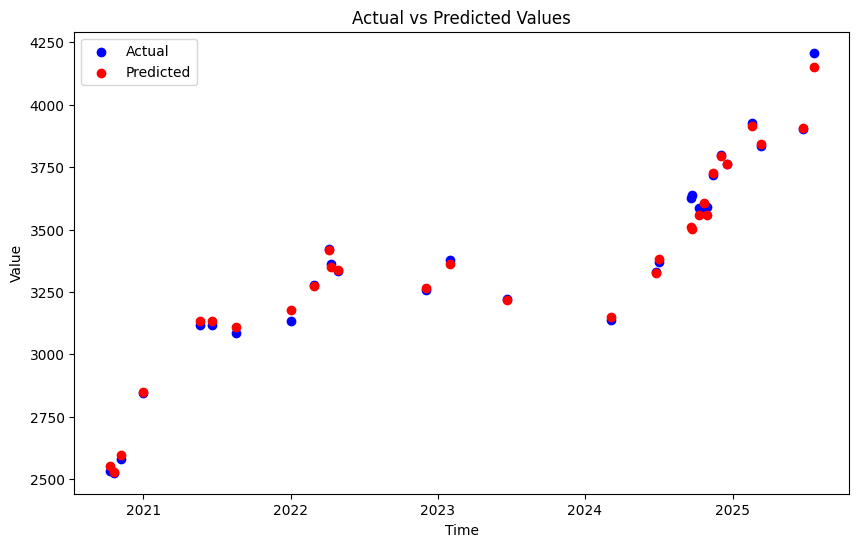

In [ ]:
# Plotting to zoom in on the first 30 points
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test_xgb[:30] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

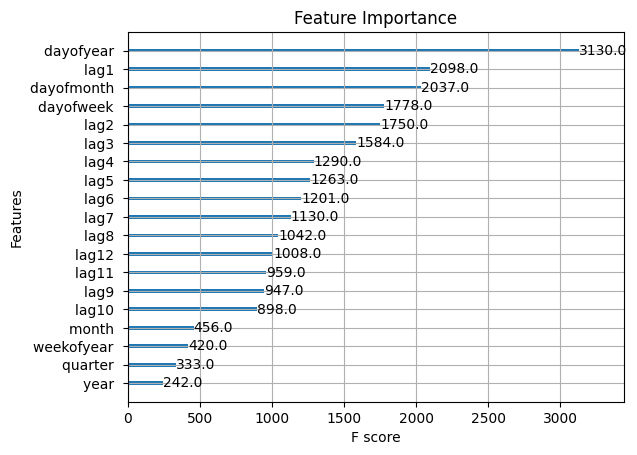

In [ ]:
# Importing the plot_importance function from xgboost
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_best, max_num_features=20)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()

## 8. Conclusion

In this analysis:
- We applied **XGBoost regression** to forecast daily STI closing prices using historical data from the last 5 years.
- Feature engineering played a key role in improving model learning.
- Hyperparameter tuning via **Optuna** ensured optimal model settings.
- Model evaluation metrics and plots helped assess accuracy.

Next steps could include:
- Adding **more advanced features** (macro indicators, technical indicators)
- Using **GARCH** models for volatility prediction
- Trying **ensemble or deep learning models** (LSTM, Transformers) for potentially better results.
